# Pypspark Lojistik Regresyon Analizi
<font size=4,font style=arial>
<br>
Kendi oluşturduğumuz veri seti üzerine Lojisitk regresyon modelini uygulayacağız. Yapacağımız analizler;<br>
--Train veri setinde lojistik modeli <br>
--Y'nin dağılım grafiği <br>
--Korelasyon grafiği <br>
--Roc alanı ve eğrisi <br>
--Test veri setinde tahminleme, positive olasılık,negatif olasılık <br>
--Precision, accuracy, sensitivity  
</font>      

<font size=4,font style=arial>
<br>
SparContext'imizi oluşturalım ve gerekli fonksiyonları yükleyelim
</font>   
    

In [1]:
 #round fonksiyonu  için
import pyspark.sql.functions as func
import pandas as pd
##Spark session oluşturulur
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import rand, randn,when,mean, min, max,sum,stddev,count,desc,col,abs
from pyspark.sql.window import Window
sc =SparkContext()
sqlContext = SQLContext(sc)
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

<font size=4,font style=arial>
<br>
Veri setimizi oluşturalım. 5 kolonlu olsun kolonlar;<br>
normal1: normal dağılımlı kolon<br>
normal2: normal dağılımlı kolon<br>
normal3: normal dağılımlı kolon<br>
normal4: normal dağılımlı kolon<br>
normal5: normal dağılımlı kolon<br>
normal6: normal dağılımlı kolon<br>
Y:0,1 dğişkenlibir kolon<br>
</font>    

In [2]:
 
df1 = sqlContext.range(0, 1000000)\
     .withColumn('normal1',func.abs(10*func.round(randn(seed=1),2)))\
     .withColumn('normal2',func.abs(100*func.round(randn(seed=2),2)))\
     .withColumn('normal3',func.abs(func.round(randn(seed=3),2)))\
     .withColumn('normal4',func.abs(func.round(randn(seed=4),2)))\
     .withColumn('normal5',func.abs(func.round(randn(seed=5),2)))\
     .withColumn('normal6',func.abs(func.round(randn(seed=6),2)))
df1.cache()

DataFrame[id: bigint, normal1: double, normal2: double, normal3: double, normal4: double, normal5: double, normal6: double]

<font size=4,font style=arial>
<br>
Y değişkenini diğer değişkenlerle ilişkilendirelim ki output değişkenimiz olan Y anlamlı olsun . Modelde 
anlamlı sonuçlar elde edelim. <br>
</font> 

In [3]:
  df1 = df1.withColumn('Y',when(df1.normal1*df1.normal2*df1.normal3*df1.normal4*df1.normal5*df1.normal6>80, 1)\
           .otherwise(0))

<font size=4,font style=arial>
<br>
Describe fonksiyonu ile nümerik değişkenlermizin mean,stddev,min,max'ını konrol edelim
</font> 

In [4]:
df1.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,1000000,499999.5,288675.2789323441,0,999999
normal1,1000000,7.979994900000167,6.024356358885466,0.0,48.8
normal2,1000000,79.815575,60.21973497812695,0.0,488.0
normal3,1000000,0.7977101699999669,0.6022875419007545,0.0,5.01
normal4,1000000,0.797668709999967,0.6027097986975427,0.0,5.01
normal5,1000000,0.7970274499999699,0.6022115700526411,0.0,5.01
normal6,1000000,0.7969538899999671,0.602614265893048,0.0,5.01
Y,1000000,0.345365,0.47548737403136476,0,1


<font size=4,font style=arial>
İki tane de kategorik değişken ekleyelim. Rastgele oluşturduğumuz normal dağılımları case when şarları  <br>
C1 kolonu A,B (2 kategory) ekleyelim<br>
C2 kolonu ZA,ZB içersin (2 kategory) ekleyelim <br>
oluşturalım.    
</font>    

In [5]:
df1=df1.withColumn('C1',when(randn(seed=2)>0.7,'A').otherwise('B'))\
         .withColumn('C2',when(randn(seed=34)>0.4,'ZA').otherwise('ZB'))  

<font size=4,font style=arial>
dataframe olduğu için veri setimiz schema'ya sahiptir(RDD'lerde bu özellik yoktur). KOlonları ve typel'lerı görelim.
</font>

In [6]:
df1.printSchema()

root
 |-- id: long (nullable = false)
 |-- normal1: double (nullable = true)
 |-- normal2: double (nullable = true)
 |-- normal3: double (nullable = true)
 |-- normal4: double (nullable = true)
 |-- normal5: double (nullable = true)
 |-- normal6: double (nullable = true)
 |-- Y: integer (nullable = false)
 |-- C1: string (nullable = false)
 |-- C2: string (nullable = false)



In [7]:
df1.sample(False, 0.001, seed=1).limit(5).show()

+----+------------------+-------+-------+-------+-------+-------+---+---+---+
|  id|           normal1|normal2|normal3|normal4|normal5|normal6|  Y| C1| C2|
+----+------------------+-------+-------+-------+-------+-------+---+---+---+
|  15| 4.699999999999999|   77.0|   0.75|   1.15|   0.35|   0.02|  0|  B| ZB|
|1889| 7.800000000000001|   75.0|   1.01|    0.6|   0.39|   0.54|  0|  A| ZA|
|1914|              14.1|  154.0|   0.78|   1.85|   0.83|   1.19|  1|  B| ZA|
|2436|2.3000000000000003|  153.0|   1.23|   0.68|   0.77|   1.59|  1|  B| ZB|
|5462|2.3000000000000003|  200.0|   0.84|   2.56|   1.44|   0.36|  1|  B| ZB|
+----+------------------+-------+-------+-------+-------+-------+---+---+---+



<font size=4,font style=arial>
Aşağıdaki kod string kolonlarda kaç kategorik seviye varı gösterir.      
</font>   

In [8]:
string_kolonlar = [t[0] for t in df1.dtypes if t[1] == 'string']
for col in string_kolonlar:
    print(col, df1.select(col).distinct().count())

C1 2
C2 2


<font size=4,font style=arial>
<br>
Aşağıda bağımlı değişkenimiz olan Y'nin hangi seviyeleri ve kaç adet olduklarını görelim.
</font> 

In [9]:
df1.groupBy('Y').count().show()

+---+------+
|  Y| count|
+---+------+
|  1|345365|
|  0|654635|
+---+------+



<font size=4,font style=arial>
Y için bir bar grafiği oluşturalım
</font> 

([<matplotlib.axis.XTick at 0x1bc80f0>, <matplotlib.axis.XTick at 0x1b95d30>],
 <a list of 2 Text xticklabel objects>)

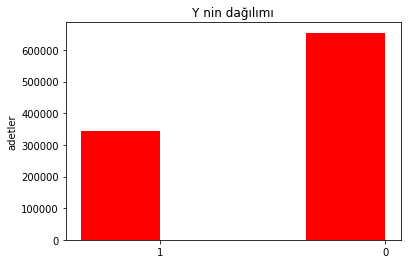

In [10]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
y_sayisi = df1.groupBy('Y').count().collect()
kategori = [i[0] for i in y_sayisi]
adet = [i[1] for i in y_sayisi]
 
ind = np.array(range(len(kategori)))
width = 0.35
plt.bar(ind, adet, width=width, color='r')
 
plt.ylabel('adetler')
plt.title('Y nin dağılımı')
plt.xticks(ind + width/2., kategori)

# Korelasyon grafiği
<font size=4,font style=arial>
<br>
Korelasyon grafiğini çizelim. Panda paketini kullanıp bütün veri setini spark driver'a alıp ram ve hafıza hatası almaktansa 
örneklem alıp onun üzerinden çalışabiliriz.
</font>

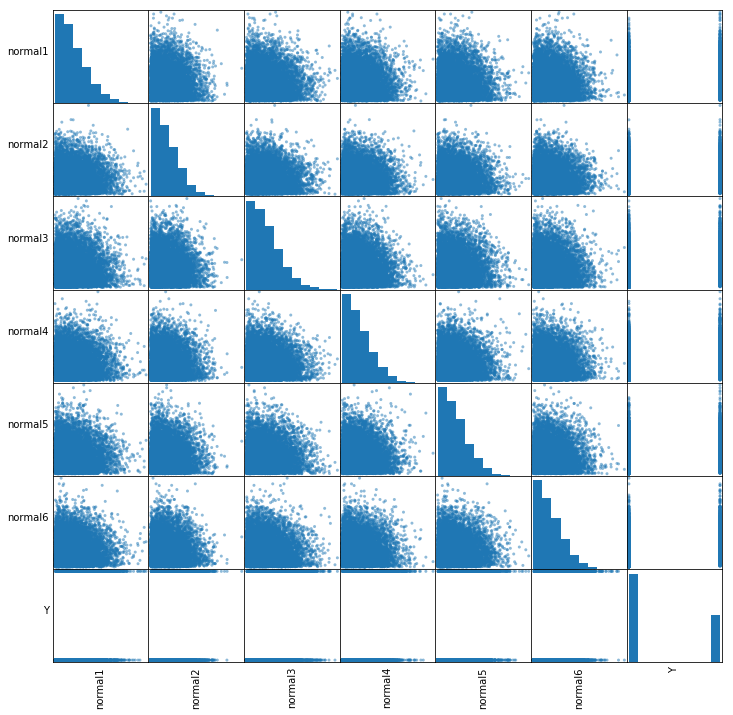

In [11]:
numerik_kolonlar = [t[0] for t in df1.dtypes if t[1] == 'int' or t[1] == 'double']

orneklem_data = df1.select(numerik_kolonlar).sample(False, 0.01).toPandas()

axs = pd.plotting.scatter_matrix(orneklem_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(orneklem_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Lojistik Regresyon

<font size=4,font style=arial>
<br>
Makina öğrenim metodu olan Lojistik Regresyon'u uygulayalım. Model modullerini yükleyelim.
</font> 

In [12]:
import numpy
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import BinaryLogisticRegressionSummary,LogisticRegression
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,MulticlassClassificationEvaluator) 

<font size=4,font style=arial>
Bağımlı değişkenimiz Y ve bağımsız değişkenlerimiz  normal1,normal2,normal3,normal4,normal5,normal6,C1,C2 olmak üzere Lojistik regresyon analizi yapalım. Spark model için bir features (bağımsız değişkenlerin oluşturduğu sparse matris) ve label(bağımlı değişken) vektörlerinin oluşturulması gerekiyor. R formula bunu oluşturmaktadır.
</font>

In [13]:
formula = RFormula(formula="Y ~ normal1+normal2+normal3+normal4+normal5+normal6+C1+C2")
output = formula.fit(df1).transform(df1)

<font size=4,font style=arial>
Modelimiz için gerekli olan features(yer kaplamaması ve işlem kolaylığı açısından oluşturulan sparse matris)  ve label kolonu oluştu. 
</font> 

In [14]:
output.show(5,truncate=False) 

+---+-------+------------------+-------+-------+-------+-------+---+---+---+----------------------------------------------------+-----+
|id |normal1|normal2           |normal3|normal4|normal5|normal6|Y  |C1 |C2 |features                                            |label|
+---+-------+------------------+-------+-------+-------+-------+---+---+---+----------------------------------------------------+-----+
|0  |10.3   |63.0              |0.92   |0.75   |0.82   |0.21   |0  |B  |ZA |[10.3,63.0,0.92,0.75,0.82,0.21,1.0,0.0]             |0.0  |
|1  |2.5    |81.0              |0.25   |1.2    |0.16   |1.85   |0  |B  |ZB |[2.5,81.0,0.25,1.2,0.16,1.85,1.0,1.0]               |0.0  |
|2  |7.0    |127.0             |0.71   |1.34   |1.8    |0.37   |1  |B  |ZB |[7.0,127.0,0.71,1.34,1.8,0.37,1.0,1.0]              |1.0  |
|3  |2.0    |77.0              |0.8    |0.57   |0.56   |0.42   |0  |B  |ZB |[2.0,77.0,0.8,0.57,0.56,0.42,1.0,1.0]               |0.0  |
|4  |7.1    |204.99999999999997|0.31   |1.08   |

<font size=4,font style=arial>
Veri setimizi %70 ve %30 şeklinde ikiye bölüp %70'de modeli kurup %30'da test edelim.
</font>

In [15]:
df1_train,df1_test=output.randomSplit([0.7,0.3],seed=0)

<font size=4,font style=arial>
Pyspark modeli için sadece features ve label kolonları gerekmektedir. Model için sadece features ve label kolonunu alacağız.
</font>

In [16]:
df2_train=df1_train.select([c for c in output.columns if c in {'features','label'}])
df2_test=df1_test.select([c for c in output.columns if c in {'features','label'}])

<font size=4,font style=arial>
Modelimizi train veri setine uygulayalım
</font>

In [17]:
final_model=LogisticRegression()
fit_final_model=final_model.fit(df2_train)

<font size=4,font style=arial>
Model Beta katsayıları aşağıdaki şekildedir
</font>   

In [18]:
print("Coefficients: " + str(fit_final_model.coefficients))
print("Intercept: " + str(fit_final_model.intercept))

Coefficients: [0.20709481535950278,0.019932140439787083,2.069220082913868,2.0643811476269165,2.0729826479536575,2.066606758607027,-0.2324162689890299,-0.0065335990823470885]
Intercept: -10.92675253533477


<font size=4,font style=arial>
Roc area and curve
</font>

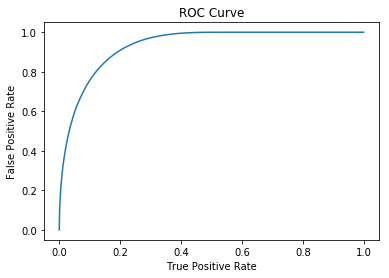

Training set areaUnderROC: 0.9322368403074464


In [19]:
testSummary = fit_final_model.summary
roc = testSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(testSummary.areaUnderROC)) 

# Test veri setimize modelimizi uygulayalım
<font size=4,font style=arial>
train setine uyguladığımız modeli test edelim
</font>

In [20]:
predictions_and_labels=fit_final_model.evaluate(df2_test)
predictions= fit_final_model.transform(df2_test).collect()

<font size=4,font style=arial>
Model accuracy
</font>

In [21]:
predictions_and_labels.accuracy

0.8489338332259432

<font size=4,font style=arial>
ROC alanı aşağıda ki gibidir
</font>

In [22]:
predictions_and_labels.areaUnderROC

0.9319839169792513

<font size=4,font style=arial>
Simdi probability ve prediction kolonlarını df2_test'e ekleyelim. Böylelikle her bir id'nin olasılık ve tahminini görebileceğiz. Aşağıda predictions dataframe'inde 3.kolonun 2.elementini(python'da index 0'dan başlar) ve 4. kolonu alalım ve df1_test'e ekleyelim.  
</font>

In [23]:
results_list = spark.createDataFrame([(float(i[3][1]),(float(i[4]))) for i in predictions])

<font size=4,font style=arial>
Görüldüğü gibi probability ve prediction kolonu results_list dataframe'ine yazıldı
</font>

In [24]:
results_list.show(5)

+--------------------+---+
|                  _1| _2|
+--------------------+---+
| 0.10114506995903719|0.0|
|0.012669347257980534|0.0|
|  0.2203881222685719|0.0|
|   0.136531808231302|0.0|
|5.303033492785747E-4|0.0|
+--------------------+---+
only showing top 5 rows



<font size=4,font style=arial>
Kolon adlarını _1'i probability,_2'yi prediction yapalım. results_list dataframe'ini join yapmaya hazır hale getirelim. Tekrar etmek gerekirse 
probability: Olay'ın olma ihtimali
prediction: 0 veya 1 olarak tahmin    
</font>

In [25]:
results_list = results_list.withColumnRenamed("_1", "probability")\
               .withColumnRenamed("_2", "prediction")

<font size=4,font style=arial>
Aşağıda results_list ile df1_test join yapabilmemiz için kodlar mevcut. Ortak hiç bir kolon olmadığı için 
</font>

In [26]:
results_list=results_list.withColumn('row_index', func.monotonically_increasing_id())
windowSpec = Window.orderBy("row_index")
results_list=results_list.withColumn("idx", func.row_number().over(windowSpec)).drop("row_index")

In [27]:
results_list.show(5)

+--------------------+----------+---+
|         probability|prediction|idx|
+--------------------+----------+---+
| 0.10114506995903719|       0.0|  1|
|0.012669347257980534|       0.0|  2|
|  0.2203881222685719|       0.0|  3|
|   0.136531808231302|       0.0|  4|
|5.303033492785747E-4|       0.0|  5|
+--------------------+----------+---+
only showing top 5 rows



In [28]:
df1_test=df1_test.withColumn('row_index', func.monotonically_increasing_id())
windowSpec = Window.orderBy("row_index")
df1_test=df1_test.withColumn("idx", func.row_number().over(windowSpec)).drop("row_index")

In [29]:
df1_test.show(5)

+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+-----+---+
| id|normal1|           normal2|normal3|normal4|normal5|normal6|  Y| C1| C2|            features|label|idx|
+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+-----+---+
|  0|   10.3|              63.0|   0.92|   0.75|   0.82|   0.21|  0|  B| ZA|[10.3,63.0,0.92,0...|  0.0|  1|
|  3|    2.0|              77.0|    0.8|   0.57|   0.56|   0.42|  0|  B| ZB|[2.0,77.0,0.8,0.5...|  0.0|  2|
|  4|    7.1|204.99999999999997|   0.31|   1.08|   0.16|   0.55|  0|  B| ZA|[7.1,204.99999999...|  0.0|  3|
|  5|    3.0|              94.0|   0.03|    0.4|   2.58|   0.17|  0|  A| ZA|[3.0,94.0,0.03,0....|  0.0|  4|
|  7|    0.4|              16.0|   0.08|   1.02|   0.09|   0.37|  0|  B| ZB|[0.4,16.0,0.08,1....|  0.0|  5|
+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+-----+---+
only showing top 5 rows



<font size=4,font style=arial>
 df1_test ve results_list sonradan kendimiz oluşturduğumuz idx kolonunda joinliyelim.
</font>

In [30]:
df3=df1_test.join(results_list, on=["idx"]).drop("features","label","idx")

<font size=4,font style=arial>
id=0 olan kolonda olayın(event) in olma ihtimali 0.2 ve prediciton'ı 0
</font>

In [31]:
df3.orderBy('idx',ascending=True).show(5)

+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+----------+
| id|normal1|           normal2|normal3|normal4|normal5|normal6|  Y| C1| C2|         probability|prediction|
+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+----------+
|  0|   10.3|              63.0|   0.92|   0.75|   0.82|   0.21|  0|  B| ZA| 0.10114506995903719|       0.0|
|  3|    2.0|              77.0|    0.8|   0.57|   0.56|   0.42|  0|  B| ZB|0.012669347257980534|       0.0|
|  4|    7.1|204.99999999999997|   0.31|   1.08|   0.16|   0.55|  0|  B| ZA|  0.2203881222685719|       0.0|
|  5|    3.0|              94.0|   0.03|    0.4|   2.58|   0.17|  0|  A| ZA|   0.136531808231302|       0.0|
|  7|    0.4|              16.0|   0.08|   1.02|   0.09|   0.37|  0|  B| ZB|5.303033492785747E-4|       0.0|
+---+-------+------------------+-------+-------+-------+-------+---+---+---+--------------------+----------+
only showing top 5 

# SENSITIVITY, PRECISION, ACCURACY
<br>
<font size=4,font style=arial>
Son olarak confusion matrisi hesaplayalım:
True Positives,True Negatives,False Positives, False Negatives
</font>

In [33]:
tp = df3[(df3.Y == 1) & (df3.prediction == 1)].count()
tn = df3[(df3.Y == 0) & (df3.prediction == 0)].count()
fp = df3[(df3.Y == 0) & (df3.prediction == 1)].count()
fn = df3[(df3.Y == 1) & (df3.prediction == 0)].count()
print ("True Positives:", tp)
print ("False Positives:", fp)
print ("True Negatives:", tn)
print ("False Negatives:", fn)
print ("Total", df3.count())

sens = float(tp)/(tp + fn)
print ("sensitivity", sens)

precision= float(tp) / (tp + fp)
print ("precision", precision)

accuracy=float(tn+tp) / (tp+tn+fp+fn)
print("accuracy",accuracy)

True Positives: 76878
False Positives: 18925
True Negatives: 177404
False Negatives: 26324
Total 299531
sensitivity 0.744927423887134
precision 0.8024592131770404
accuracy 0.8489338332259432


<font size=4,font style=arial>
Yukarıda manual hesapladığımız değerler aşağıda built in fonksiyonlarlada hesaplanabilir.
</font>

In [ ]:
predictions_and_labels.truePositiveRateByLabel

In [ ]:
predictions_and_labels.accuracy

In [ ]:
predictions_and_labels.recallByLabel